AlexNet基于一种想法：特征本身应该被学习

同时，在合理的复杂性前提下，特征应该由多个共同学习的神经网络层组成，每个层都有可学习的参数。

核心创新
1. 更深更大的网络架构
    - 更多层次：包含5个卷积层和3个全连接层，比LeNet深得多
    - 更大容量：参数量达到约6000万个，远超LeNet
    - 更多通道：第一层就有96个输出通道，是LeNet的10多倍
2. ReLU激活函数的使用
    - 替代了LeNet中的sigmoid激活函数
    - 解决了深度网络中的梯度消失问题
    - 训练速度更快，正区间梯度恒为1，有效促进网络收敛
3. Dropout正则化
    - 首次在CNN中引入Dropout来抑制过拟合
    - 随机关闭50%的神经元，阻止网络过度依赖某些特征路径
    - LeNet只使用权重衰减作为正则化方法
4. 数据增强技术
    - 引入了翻转、裁切、变色等数据增强方法
    - 有效增加训练样本多样性，提高泛化能力
    - 这一技术现已成为计算机视觉中的标准实践

特征学习的体现
AlexNet体现"特征应该被学习"这一理念的方式：
1. 层次化特征表示：
    - 浅层学习边缘、纹理等低级特征
    - 中层学习形状、部件等中级特征
    - 深层学习高级语义概念
2. 自动特征提取：
    - 不依赖手工设计的特征提取器
    - 通过大量数据驱动学习最优特征表示
    - 每一个卷积核都是在学习一种特定的视觉模式
3. 可学习参数的增加：
    - 大量可学习的卷积核（从LeNet的6个到AlexNet的96个）
    - 更大的感受野捕获复杂特征（11×11的卷积核）
    - 多层次组合创建更抽象的特征表示

模型设计：<br>
在AlexNet的第一层，卷积窗口的形状是11x11。 由于ImageNet中大多数图像的宽和高比MNIST图像的多10倍以上，因此，需要一个更大的卷积窗口来捕获目标。 第二层中的卷积窗口形状被缩减为5x5，然后是3x3。 此外，在第一层、第二层和第五层卷积层之后，加入窗口形状为3x3、步幅为2的最大汇聚层。 而且，AlexNet的卷积通道数目是LeNet的10倍。<br>
在最后一个卷积层后有两个全连接层，分别由4096个输出

此外，AlexNet将sigmoid激活函数改为更简单的ReLU激活函数

一方面，ReLU激活函数的计算更简单，它不需要如sigmoid激活函数那般复杂的求幂运算。 另一方面，当使用不同的参数初始化方法时，ReLU激活函数使训练模型更加容易。 当sigmoid激活函数的输出非常接近于0或1时，这些区域的梯度几乎为0，因此反向传播无法继续更新一些模型参数。 相反，ReLU激活函数在正区间的梯度总是1。 因此，如果模型参数没有正确初始化，sigmoid函数可能在正区间内得到几乎为0的梯度，从而使模型无法得到有效的训练。

AlexNet通过Dropout控制全连接层的模型复杂度，而LeNet只使用了权重衰减<br>
为了进一步扩充数据，AlexNet在训练时增加了大量的图像增强数据，如翻转、裁切和变色。 这使得模型更健壮，更大的样本量有效地减少了过拟合

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet

    # 当你创建 nn.Conv2d 层时：
        # PyTorch 自动初始化所有96个卷积核的权重（通常使用Kaiming或Xavier初始化）
        # 这些卷积核在训练过程中被优化，以学习不同的特征提取器
        # 第一层卷积核通常会学习检测边缘、纹理、颜色等低级特征
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    # 在参数最多的全连接层后添加Dropout来减轻过拟合

    # 因为AlexNet参数量大，因此需要减轻过拟合和减小依赖性，同时还能集成学习效果并提高泛化能力
    nn.Dropout(p=0.5),  # 以概率p=0.5将随机神经元的输出设为0，来阻止神经元共适应
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

构造一个高度和宽度都为224的单通道数据，来观察每一层输出的形状。 

In [2]:
X = torch.randn(1, 1, 224, 224)  # torch.randn() 函数从标准正态分布（均值为0，方差为1）中抽取随机数来初始化张量。其参数表示张量的形状。
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

尽管原文中AlexNet是在ImageNet上进行训练的，但本书在这里使用的是Fashion-MNIST数据集。因为即使在现代GPU上，训练ImageNet模型，同时使其收敛可能需要数小时或数天的时间。 将AlexNet直接应用于Fashion-MNIST的一个问题是，Fashion-MNIST图像的分辨率（28x28像素）低于ImageNet图像。 为了解决这个问题，我们将它们增加到224 x 224
（通常来讲这不是一个明智的做法，但在这里这样做是为了有效使用AlexNet架构）。 <br>
这里需要使用d2l.load_data_fashion_mnist函数中的resize参数执行此调整。

In [3]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

现在AlexNet可以开始被训练了。与 6.6节中的LeNet相比，这里的主要变化是使用更小的学习速率训练，这是因为网络更深更广、图像分辨率更高，训练卷积神经网络就更昂贵。

loss 0.329, train acc 0.879, test acc 0.881
1006.9 examples/sec on cuda:0


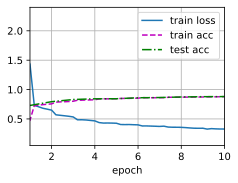

In [4]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())